# INTRODUCTION


In this notebook we will be using the following packages:
  * [pyspark](https://spark.apache.org/docs/latest/api/python/pyspark.html)
  * [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html)
  * [pyarrow](https://arrow.apache.org/docs/python/index.html)

## Specifications of the problem
We are tasked to construct a recommender system as part of the recsyschallenge of 2022, organised by Dressipi, a company focused on providing product and outfit recommendations to leading global retailers.

## Dataset
The full dataset consists of 1.1 million online retail sessions in the fashion domain, sampled from a 18-month period.

It is split in 4 csv files:
   * candidate_items.csv : contains the candidate items for the recommender system. This means our model will provide those item_id as output of the prediction.
   * item_features.csv : contains the features (for example material, type, colour, etc ... ) for each item, as well as the value of this feature (cotton, skinny, blue, etc ...)
   * train_purchases.csv : contains the purchases at the end of each session.
   * train_sessions.csv : contains the purchasing sessions, each session is a stream of items viewed, and when an item is purchased, the session ends.

Using those 4 files, we will first develop a pipeline to trim it, then engineer the features to regroup different features into one dataset so that it can be used for the recommender system.


## Loading the dataset

In [94]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
import os

# start spark session
os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=8g  pyspark-shell"
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("AppName") \
    .config('spark.ui.port', '4055')\
    .getOrCreate()

candidate_items, item_features, train_purchases, train_sessions = [None] * 4
datasets = [candidate_items, item_features, train_purchases, train_sessions]

#load all datasets
def load_candidate_items():
    global candidate_items
    candidate_items = spark.read.csv("dressipi_recsys2022/candidate_items.csv", header=True)
    candidate_items = candidate_items.withColumn("item_id", candidate_items["item_id"].cast("int"))

def load_item_features():
    global item_features
    item_features = spark.read.csv("dressipi_recsys2022/item_features.csv", header=True)
    item_features = item_features.withColumn("item_id", item_features["item_id"].cast("int"))
    item_features = item_features.withColumn("feature_category_id", item_features["feature_category_id"].cast("int"))
    item_features = item_features.withColumn("feature_value_id", item_features["feature_value_id"].cast("int"))

def load_train_purchases():
    global train_purchases
    train_purchases = spark.read.csv("dressipi_recsys2022/train_purchases.csv", header=True)
    train_purchases = train_purchases.withColumn("session_id", train_purchases["session_id"].cast("int"))
    train_purchases = train_purchases.withColumn("item_id", train_purchases["item_id"].cast("int"))
    train_purchases = train_purchases.withColumn("date", train_purchases["date"].cast("timestamp"))

def load_train_sessions():
    global train_sessions
    train_sessions = spark.read.csv("dressipi_recsys2022/train_sessions.csv", header=True)
    train_sessions = train_sessions.withColumn("session_id", train_sessions["session_id"].cast("int"))
    train_sessions = train_sessions.withColumn("item_id", train_sessions["item_id"].cast("int"))
    train_sessions = train_sessions.withColumn("date", train_sessions["date"].cast("timestamp"))

def load_datasets():
    global datasets
    load_candidate_items()
    load_item_features()
    load_train_purchases()
    load_train_sessions()
    datasets = [candidate_items, item_features, train_purchases, train_sessions]

load_datasets()


## Quick look at the data

#### train_sessions.csv
This dataset represents the browsing session of a user in the store. It is made of 3 columns:
- session_id : the id of the session. It serves as a key to join the data with the other datasets
- item_id : the item viewed during the session.
- date : the date of at wich the item was viewed.

Please note that the browsing sessions end at the end of the day, or if an item was purchased. This means we will not find, for one session, items viewed on 2 different days.
Also, as stated on the challenge's website, there are no sessions that do not end with a purchased item in this dataset.

Here is a representation of a few of the rows in the train_sessions.csv dataset:

In [3]:
train_sessions.show(5)
print(f"There are {train_sessions.count()} rows in total.")

+----------+-------+--------------------+
|session_id|item_id|                date|
+----------+-------+--------------------+
|         3|   9655|2020-12-18 21:25:...|
|         3|   9655|2020-12-18 21:19:...|
|        13|  15654|2020-03-13 19:35:...|
|        18|  18316|2020-08-26 19:18:...|
|        18|   2507|2020-08-26 19:16:...|
+----------+-------+--------------------+
only showing top 5 rows

There are 4743820 rows in total.


#### train_purchases.csv

This dataset represents the purchases made by a user in the store. It is made of 3 columns:
- session_id : the id of the session.
- item_id : the item purchased.
- date : the date of at wich the item was purchased.

This dataset should be used with the train_sessions dataset to have a more complete picture of the browsing experience of the user. Each session in this dataset ends with an item purchased, noted in the column item_id.

Here is a representation of a few of the rows in the train_purchases.csv dataset:

In [4]:
train_purchases.show(5)
print(f"There are {train_purchases.count()} rows in total.")

+----------+-------+--------------------+
|session_id|item_id|                date|
+----------+-------+--------------------+
|         3|  15085|2020-12-18 21:26:...|
|        13|  18626|2020-03-13 19:36:...|
|        18|  24911|2020-08-26 19:20:...|
|        19|  12534|2020-11-02 17:16:...|
|        24|  13226|2020-02-26 18:27:...|
+----------+-------+--------------------+
only showing top 5 rows

There are 1000000 rows in total.


#### item_features.csv

This dataset helps us notice pattern in different objects. It links the item_id with their feature (such as the color of the item, the material, the type, etc ...).
There are 3 columns :
- item_id : the id of the item in the store.
- feature_id : the id of the feature attached to the item.
- value : the value of the feature for that item. (for example if the feature_category_id is the color, the feature_value_id could be a representation of "red", "blue", "green", etc ...)

Here is a representation of a few of the rows in the item_features.csv dataset:

In [5]:
item_features.show(5)
print(f"There are {item_features.count()} rows in total.")

+-------+-------------------+----------------+
|item_id|feature_category_id|feature_value_id|
+-------+-------------------+----------------+
|      2|                 56|             365|
|      2|                 62|             801|
|      2|                 68|             351|
|      2|                 33|             802|
|      2|                 72|              75|
+-------+-------------------+----------------+
only showing top 5 rows

There are 471751 rows in total.


#### candidate_items.csv

This dataset contains all the item_id that are candidate to the recommandation system. It consists of a column of 4991 item_id.

Here is a representation of a few of the rows in the candidate_items.csv dataset:

In [6]:
candidate_items.show(5)
print(f"There are {candidate_items.count()} rows in total.")

+-------+
|item_id|
+-------+
|      4|
|      8|
|      9|
|     19|
|     20|
+-------+
only showing top 5 rows

There are 4990 rows in total.


# Part 1 : Pipeline

## Data exploration

We will first check if there are missing values, NA, or Null values in the downloaded dataset.

In [7]:
print("Nb of missing values in candidate_items:", candidate_items.filter(candidate_items["item_id"].isNull()).count())
print("Nb of missing values in item_features:", item_features.filter(item_features["item_id"].isNull()).count())
print("Nb of missing values in train_purchases:", train_purchases.filter(train_purchases["item_id"].isNull()).count())
print("Nb of missing values in train_sessions:", train_sessions.filter(train_sessions["item_id"].isNull()).count())

Nb of missing values in candidate_items: 0
Nb of missing values in item_features: 0
Nb of missing values in train_purchases: 0
Nb of missing values in train_sessions: 0


Now, we wondered if there are sessions for which the first item viewed was purchased (therefore it will not be in train_sessions but in train_purchases), and we also made sure that there are no sessions for which there were no purchases.

In [8]:
t = [a["session_id"] for a in train_sessions.select("session_id").collect()]
p = [a["session_id"] for a in train_purchases.select("session_id").collect()]

print(f"Nb of session id in train_sessions but not in train_purchases: {len(set(t).difference(set(p)))}")
print(f"Nb of session id in train_purchases but not in train_sessions: {len(set(p).difference(set(t)))}")

Nb of session id in train_sessions but not in train_purchases: 0
Nb of session id in train_purchases but not in train_sessions: 0


Then we wanted to know how much data we were working with so we counted the number of different item_id in each dataset.

In [9]:
a = train_sessions.select("item_id").distinct().collect()
b = train_purchases.select("item_id").distinct().collect()
c = candidate_items.select("item_id").distinct().collect()
d = item_features.select("item_id").distinct().collect()
print(f"Nb of distinct item id in train_sessions: {len(a)}")
print(f"Nb of distinct item id in train_purchases: {len(b)}")
print(f"Nb of distinct item id in candidate_items: {len(c)}")
print(f"Nb of distinct item id in item_features: {len(d)}")

Nb of distinct item id in train_sessions: 23496
Nb of distinct item id in train_purchases: 18907
Nb of distinct item id in candidate_items: 4990
Nb of distinct item id in item_features: 23691


We cannot know if those items are the same or different, but by running the next cell we discover that there are no items in train_sessions that are not in another dataset. Therefore we know that we have at least 23496 items.

In [10]:
print(f"Nb of item id in train_sessions but not in item_features: {len(set(a).difference(set(d)))}")
print(f"Nb of item id in train_sessions but not in train_purchases: {len(set(b).difference(set(d)))}")
print(f"Nb of item id in train_sessions but not in candidate_items: {len(set(c).difference(set(d)))}")

Nb of item id in train_sessions but not in item_features: 0
Nb of item id in train_sessions but not in train_purchases: 0
Nb of item id in train_sessions but not in candidate_items: 0


In [65]:
item_features.drop("item_id").distinct().groupBy("feature_category_id").agg(F.count("feature_value_id")).agg(F.sum("count(feature_value_id)")).collect()

[Row(sum(count(feature_value_id))=904)]

## Feature engineering

First let's create usefull RDDs from the dataset

In [95]:
session_item_date_rdd = train_sessions.rdd.map(lambda x: (x["session_id"], (x["item_id"], x["date"]))).cache()
session_item_rdd = session_item_date_rdd.mapValues(lambda x: (x[0])).cache()
session_date_rdd = session_item_date_rdd.mapValues(lambda x: (x[1])).cache()

In [96]:
purchase_item_rdd = train_purchases.rdd.map(lambda x: (x["session_id"], x["item_id"])).cache()

In [97]:
item_features_rdd = item_features.rdd.map(lambda x: (x["item_id"], (x["feature_category_id"], x["feature_value_id"]))).groupByKey().mapValues(lambda x: [(a,b) for a, b in x])

1) Month

    It tells us in which month the session began.

    The pieces of clothes bought most likely depend on the month of the purchase. The purchases of sweaters should not be the same in december and in july.

In [14]:
def get_month_feature():
    return session_date_rdd.mapValues(lambda x: int(x.strftime("%m"))).reduceByKey(min)
    
month = get_month_feature()
print(month.take(5))

[(24, 2), (48, 4), (384, 12), (480, 4), (696, 3)]


2) Season (Meteorological)

    It tells us in which meteorological season the session began.
    
    Maybe the month feature is too restrictive and needs bigger categories.


In [15]:
def get_season_feature():
    return month.mapValues(get_season).reduceByKey(min)

def get_season(month):
    if month == 12 or month <= 2: return 0.0
    elif 2 < month <= 5: return 1
    elif 5 < month <= 8: return 2
    elif 8 < month <= 11: return 3

season = get_season_feature()
print(season.take(5))

[(24, 0.0), (48, 1), (384, 0.0), (480, 1), (696, 1)]


3) Day of month

    It tells us at which day of the month the session began.
    
    The salaries are often paid at the start or the middle of the month, and should affect the purchases.


In [16]:
def get_day_of_month_feature():
    return session_date_rdd.mapValues(lambda x: int(x.strftime("%d"))).reduceByKey(min)

day_of_month = get_day_of_month_feature()
print(day_of_month.take(5))

[(24, 26), (48, 15), (384, 18), (480, 4), (696, 18)]


4) Weekday

    It tells us at which weekday the session began.
    
    ?


In [17]:
def get_weekday_feature():
    return session_date_rdd.mapValues(lambda x: int(x.strftime("%w"))).reduceByKey(min)
weekday = get_weekday_feature()
print(weekday.take(5))

[(24, 3), (48, 3), (384, 5), (480, 0), (696, 3)]


5) Weekend

    It tells us if the session began on a weekend.
    
    Maybe the weekday feature is too specific and the ?


In [18]:
def get_weekend_feature():
    return weekday.mapValues(lambda x: int(x in (5, 6)))

weekend = get_weekend_feature()
print(weekend.take(5))

[(24, 0), (48, 0), (384, 1), (480, 0), (696, 0)]


6) Hour

    It tells us at which hour the session began.
    
    ?


In [19]:
def get_hour_feature():
    return session_date_rdd.mapValues(lambda x: int(x.strftime("%H"))).reduceByKey(min)

hour = get_hour_feature()
print(hour.take(5))

[(24, 17), (48, 17), (384, 8), (480, 11), (696, 8)]


7) Day period

    It tells us at which period of the day the session began.
    
    Maybe the hour feature is too restrictive ?


In [20]:
def get_day_period_feature():
    return hour.mapValues(get_day)

def get_day(x):
    if 6 < x < 12: return 0
    elif 12 < x < 18: return 1
    elif 18 < x < 22: return 2
    else: return 3
    
day_period = get_day_period_feature()
print(day_period.take(5))

[(24, 1), (48, 1), (384, 0), (480, 0), (696, 0)]


8) Night

    It tells us if the session began at night.
    
    Maybe the day period feature is still too restrictive ?


In [21]:
def get_night_feature():
    return day_period.mapValues(lambda x: int(x == 3))

night = get_night_feature()
print(night.take(5))

[(24, 0), (48, 0), (384, 0), (480, 0), (696, 0)]


9) Duration of the session

    It tells us the duration of the session.
    
    ?


In [22]:
def get_duration_feature():
    return session_date_rdd.groupByKey().mapValues(get_session_duration)

def get_session_duration(dates):
    dates = list(dates)
    dates.sort()
    return (dates[-1] - dates[0]).total_seconds() if len(dates) >= 2 else 0.0

duration = get_duration_feature()
print(duration.take(5))

[(24, 3703.867), (48, 657.103), (384, 408.871), (480, 392.229), (696, 27.229)]


10) Average time between consecutive item views

    It tells us the average of time between the consecutive views of the items of the session.
    
    ?


In [23]:
def get_average_time_feature():
    return session_date_rdd.groupByKey().mapValues(get_average_time)

def get_average_time(dates):
    import datetime
    dates = sorted(list(dates))
    avgs = [dates[i+1] - dates[i] for i in range(len(dates)-1)]
    return (sum(avgs, datetime.timedelta())/len(avgs)).total_seconds() if len(avgs) > 0 else 0.0

average_time = get_average_time_feature()

print(average_time.take(5))

[(24, 462.983375), (48, 657.103), (384, 45.430111), (480, 196.1145), (696, 27.229)]


11) Number of distinct items

    It tells us the number of distinct items viewed in the session.
    
    ?

In [24]:
def get_distinct_nb_feature():
    return session_item_rdd.groupByKey().mapValues(lambda x: len(set(x)))

distinct_nb = get_distinct_nb_feature()
print(distinct_nb.take(5))

[(24, 8), (48, 2), (384, 10), (480, 3), (696, 2)]


12) Number of repetitive items

    It tells us ?
    
    ?

In [25]:
def get_repetitive_nb_feature():
    return session_item_rdd.groupByKey().mapValues(lambda x: len(list(x)) - len(set(x)))

repetitive_nb = get_repetitive_nb_feature()
print(repetitive_nb.take(5))

[(24, 1), (48, 0), (384, 0), (480, 0), (696, 0)]


13) Same category


    It tells us the number of categories which appear at least twice in the items of the session.
    
    ?

In [26]:
def get_same_category_feature():
    return item_features_rdd.join(train_sessions.rdd.map(lambda x: (x["item_id"], x["session_id"]))).map(lambda x: (x[1][1], x[1][0])).groupByKey().mapValues(get_same_category)

def get_same_category(x):
    dico = dict()
    for item in x:
        for cat in item:
            if cat in dico:
                dico[cat] += 1
            else:
                dico[cat] = 0

    res = 0
    for val in dico.values():
        if val > 0:
            res += 1

    return res

same_category = get_same_category_feature()
print(same_category.take(5))

[(165334, 25), (429494, 42), (480350, 116), (588952, 46), (866528, 38)]


14) Different category

    It tells us ?
    
    ?

In [27]:
def get_diff_category():
    return item_features_rdd.join(train_sessions.rdd.map(lambda x: (x["item_id"], x["session_id"]))).map(lambda x: (x[1][1], x[1][0])).groupByKey().mapValues(get_different_category)

def get_different_category(x):
    dico = dict()
    for item in x:
        for cat in item:
            if cat in dico:
                dico[cat] += 1
            else:
                dico[cat] = 0

    res = 0
    for val in dico.values():
        if val == 0:
            res += 1

    return res

diff_category = get_diff_category()
print(diff_category.take(5))

[(165334, 28), (429494, 32), (480350, 51), (588952, 23), (866528, 2)]


15) Last item

    It tells us the last item that was seen in the session.
    
    The last item seen in the session should be closer to the purchased item than the first one.

In [28]:
def get_last_item_feature():
    return session_item_date_rdd.groupByKey().mapValues(lambda x: max(x, key=lambda i: i[1])[0])

def get_last_item(items):
    return max(list(items), key=lambda i: i[1])[0]

last_item = get_last_item_feature()
print(last_item.take(5))

[(24, 18476), (48, 26404), (384, 27183), (480, 16377), (696, 24687)]


16) Most present category

    It tells us the most present category in the different items seen in the session.
    
    The most present category should be highly be related to the purchased item.

In [29]:
def get_most_present_category_feature():
    return item_features_rdd.join(train_sessions.rdd.map(lambda x: (x["item_id"], x["session_id"]))).map(lambda x: (x[1][1], x[1][0])).groupByKey().mapValues(get_most_present_category)

def get_most_present_category(categories_i):
    categories = [cat for cat_i in categories_i for cat in cat_i]    
    categories.sort()
    
    most_viewed = (None, -1)
    last_viewed = categories[0]
    cnt = 0
    
    for category in categories:
        if last_viewed != category:
            if cnt > most_viewed[1]:
                most_viewed = (last_viewed, cnt)
                cnt = 1
                last_viewed = category
        else:
            cnt += 1
            
    if cnt > most_viewed[1]:
        most_viewed = (last_viewed, cnt)
    
    return most_viewed[0]
    
most_present_category = get_most_present_category_feature()
print(most_present_category.take(5))

[(165334, (3, 793)), (429494, (3, 793)), (480350, (1, 461)), (588952, (3, 793)), (866528, (3, 793))]


17) Most viewed item

    It tells us the most seen item in the session.
    
    The most seen item should be highly be related to the purchased item.

In [30]:
def get_most_viewed_item_feature():
    return session_item_rdd.groupByKey().mapValues(get_most_viewed_item)

def get_most_viewed_item(items):
    items = list(items)
    items.sort()
    most_viewed = (None, -1)
    
    last_viewed = items[0]
    cnt = 0
    
    for item in items:
        if last_viewed != item:
            if cnt > most_viewed[1]:
                most_viewed = (last_viewed, cnt)
                cnt = 1
                last_viewed = item
        else:
            cnt += 1
            
    if cnt > most_viewed[1]:
        most_viewed = (last_viewed, cnt)
    
    return most_viewed[0]
    
most_viewed_item = get_most_viewed_item_feature()
print(most_viewed_item.take(5))

[(24, 2927), (48, 8398), (384, 784), (480, 2915), (696, 22090)]


18) Length of the session

    It tells us the number of items seen in the session.
    
    ?

In [31]:
def get_length_feature():
    return session_item_rdd.groupByKey().mapValues(len)

length = get_length_feature()
print(length.take(5))

[(24, 9), (48, 2), (384, 10), (480, 3), (696, 2)]


19) Longest viewed item

    It tells us the item that was seen the longest in the session.
    
    The longest viewed item should be highly related to the purchased item as it tells us that the user was most likely interested in it.

In [32]:
def get_longest_item_feature():
    return train_sessions.rdd.map(lambda x: (x["session_id"], (x["item_id"], x["date"]))).\
                    groupByKey().\
                    mapValues(get_longest_item)

def get_longest_item(items):
    items = list(items)
    t = [items[i+1][1] - items[i][1] for i in range(len(items)-1)]
    return items[np.argmax(t)][0] if len(t) > 0 else items[0][0]

longest_item = get_longest_item_feature()
print(longest_item.take(5))

[(24, 2927), (48, 8398), (384, 9582), (480, 2915), (696, 22090)]


20) Most present number of categories
    
    It tells us the most present number of categories of the items seen in the session.
    
    The number of categories of an item should be closely related to its type.


In [33]:
def get_categories_nb_feature():
    return item_features_rdd.join(train_sessions.rdd.map(lambda x: (x["item_id"], x["session_id"]))).map(lambda x: (x[1][1], x[1][0])).groupByKey().mapValues(get_categories_nb)

def get_categories_nb(cat):
    lst = [len(c) for c in cat]
    return float(max(set(lst), key=lst.count))
    
categories_nb = get_categories_nb_feature()
print(categories_nb.take(5))

[(165334, 25.0), (429494, 25.0), (480350, 24.0), (588952, 25.0), (866528, 26.0)]


21) Hash (MAYBE CHANGE THIS) Compressed 
    
    It tell us the hash of the item set seen in the session, it is a compromise with the hot encoding of all the items as it would take too much space.
    
    Two identic sets of seen items would most likely end up with the same purchased item.


In [34]:
def get_hash_items_feature():
    return session_item_rdd.groupByKey().mapValues(lambda x: abs(hash(str(list(x)))))

hash_items = get_hash_items_feature()
print(hash_items.take(5))

[(24, 5971015408950527618), (48, 7832911270832295574), (384, 5575645549726496508), (480, 6686949616036238645), (696, 1515478092954498483)]


21) Item hot encoding

In [98]:

def get_item_hot_encoding_feature():
    return session_item_rdd.groupByKey().mapValues(get_item_hot_encoding)

def get_item_hot_encoding(x):
    res = [0] * len(broadcast_item_to_index.value)
    for item in x:
        res[broadcast_item_to_index.value[item]] = 1
    return res

item_to_index = {}
i = 0
for item in item_features.select("item_id").distinct().collect():
    item_to_index[item["item_id"]] = i
    i += 1

broadcast_item_to_index = spark.sparkContext.broadcast(item_to_index)
    
item_hot_encoding = get_item_hot_encoding_feature()

In [75]:
list(item_to_index.keys())[:2]

[148, 471]

In [80]:
len(item_to_index)

23691

In [99]:
item_hot_encoding.take(1)

[(24,
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0

## Joining features

All of these engineered features will be put in the same RDD with the id of the session as the key and the different features as the value.

This will be done through consecutive join's on the key.

In [35]:
# features = [month, season, day_of_month, weekday, weekend, hour, day_period, night, duration, average_time, distinct_nb, repetitive_nb, same_category, diff_category, last_item, most_present_category, most_viewed_item, length, longest_item, categories_nb, hash_items]
# features_name = ["month", "season", "day_of_month", "weekday", "weekend", "hour", "day_period", "night", "duration", "average_time", "distinct_nb", "repetitive_nb", "same_category", "diff_category", "last_item", "most_present_category", "most_viewed_item", "length", "longest_item", "categories_nb", "hash_items"]

features = [month, season, day_of_month, weekday, weekend, hour, day_period, night, duration, average_time, distinct_nb, repetitive_nb, same_category, diff_category, last_item, most_viewed_item, length, longest_item, categories_nb]
features_name = ["month", "season", "day_of_month", "weekday", "weekend", "hour", "day_period", "night", "duration", "average_time", "distinct_nb", "repetitive_nb", "same_category", "diff_category", "last_item", "most_viewed_item", "length", "longest_item", "categories_nb"]

def get_full_rdd():
    temp = purchase_item_rdd.join(features[0])
    for i in range(1, len(features)):
        feature = features[i]
        temp = temp.join(feature).mapValues(lambda x: list(x[0])+[x[1]])
    return temp

BIG_RDD = get_full_rdd().cache()

In [36]:
print(BIG_RDD.take(1))

[(4191900, [12090, 10, 3, 11, 0, 0, 12, 3, 1, 801.765, 400.8825, 3, 0, 14, 28, 5257, 4537, 3, 22402, 18.0])]


In [37]:
aha ha # TEST

SyntaxError: invalid syntax (<ipython-input-37-531f1a2fbc02>, line 1)

# Part 2 : Feature selection


## Ranking algorithm

For the ranking algorithm we chose the Pearson correlation coefficient.

We fully implemented it in map/reduce using the following formula.

${\displaystyle r_{xy}={\frac {n\sum x_{i}y_{i}-\sum x_{i}\sum y_{i}}{{\sqrt {n\sum x_{i}^{2}-\left(\sum x_{i}\right)^{2}}}~{\sqrt {n\sum y_{i}^{2}-\left(\sum y_{i}\right)^{2}}}}}.}$

source : https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

In [56]:
def pearson_reduce(a, b):
    n = a[0] + b[0]
    x = a[1] + b[1]
    y = a[2] + b[2]
    x2 = a[3] + b[3]
    y2 = a[4] + b[4]
    xy = a[5] + b[5]

    return n, x, y, x2, y2, xy

def calculate_pearson(a):
    import math

    n = a[0]
    x = a[1]
    y = a[2]
    x2 = a[3]
    y2 = a[4]
    xy = a[5]

    return (n*xy - x * y) / (math.sqrt((n*x2 - (x**2)) * (n*y2 - (y**2))))

def compute_pearson(rdd):
    temp = rdd.flatMap(lambda x: [((i, j), (x[1][i], x[1][j])) for i in range(len(x[1])) for j in range(i+1, len(x[1]))]).\
        mapValues(lambda a: (1, a[0], a[1], a[0]**2, a[1]**2, a[0]*a[1])).\
        reduceByKey(pearson_reduce).\
        mapValues(calculate_pearson)
    return temp

Here we can see the features which correlates the most with another one.

In [57]:
features_score_rdd = compute_pearson(BIG_RDD)
features_score = features_score_rdd.collect()
features_score.sort(key=lambda x: abs(x[1]), reverse=True)

names = ["label"] + features_name 

print("Features ranking:")
for feat in features_score:
    print(f"\t- {names[feat[0][0]]}, {names[feat[0][1]]}: {feat[1]}")

Features ranking:
	- distinct_nb, length: 0.9695675322955418
	- same_category, length: 0.8771412318346528
	- distinct_nb, same_category: 0.8747125297247733
	- weekday, weekend: 0.8115747837608694
	- day_period, night: 0.8065095172832625
	- repetitive_nb, length: 0.6950975912677149
	- duration, average_time: 0.6608983332947496
	- month, season: 0.6233941124223703
	- most_viewed_item, longest_item: 0.5464755879768183
	- last_item, most_viewed_item: 0.5413883807901063
	- repetitive_nb, same_category: 0.5384459913705446
	- distinct_nb, diff_category: 0.5196139193089427
	- distinct_nb, repetitive_nb: 0.4979363010038509
	- same_category, most_viewed_item: -0.46302715116708343
	- last_item, longest_item: 0.44988032693378127
	- diff_category, length: 0.4301693973966943
	- distinct_nb, most_viewed_item: -0.4144867681260636
	- most_viewed_item, length: -0.3887090686727713
	- same_category, diff_category: 0.34523725759759144
	- duration, same_category: 0.31322897238753117
	- duration, length: 0.3

In [58]:
mat = [[0] * len(names) for i in range(len(names))]
for feat in features_score:
    i,j = feat[0]
    mat[j][i] = feat[1]
    mat[j][j] = 1
    mat[i][i] = 1

Here we show a matrix containing these correlation coefficient.

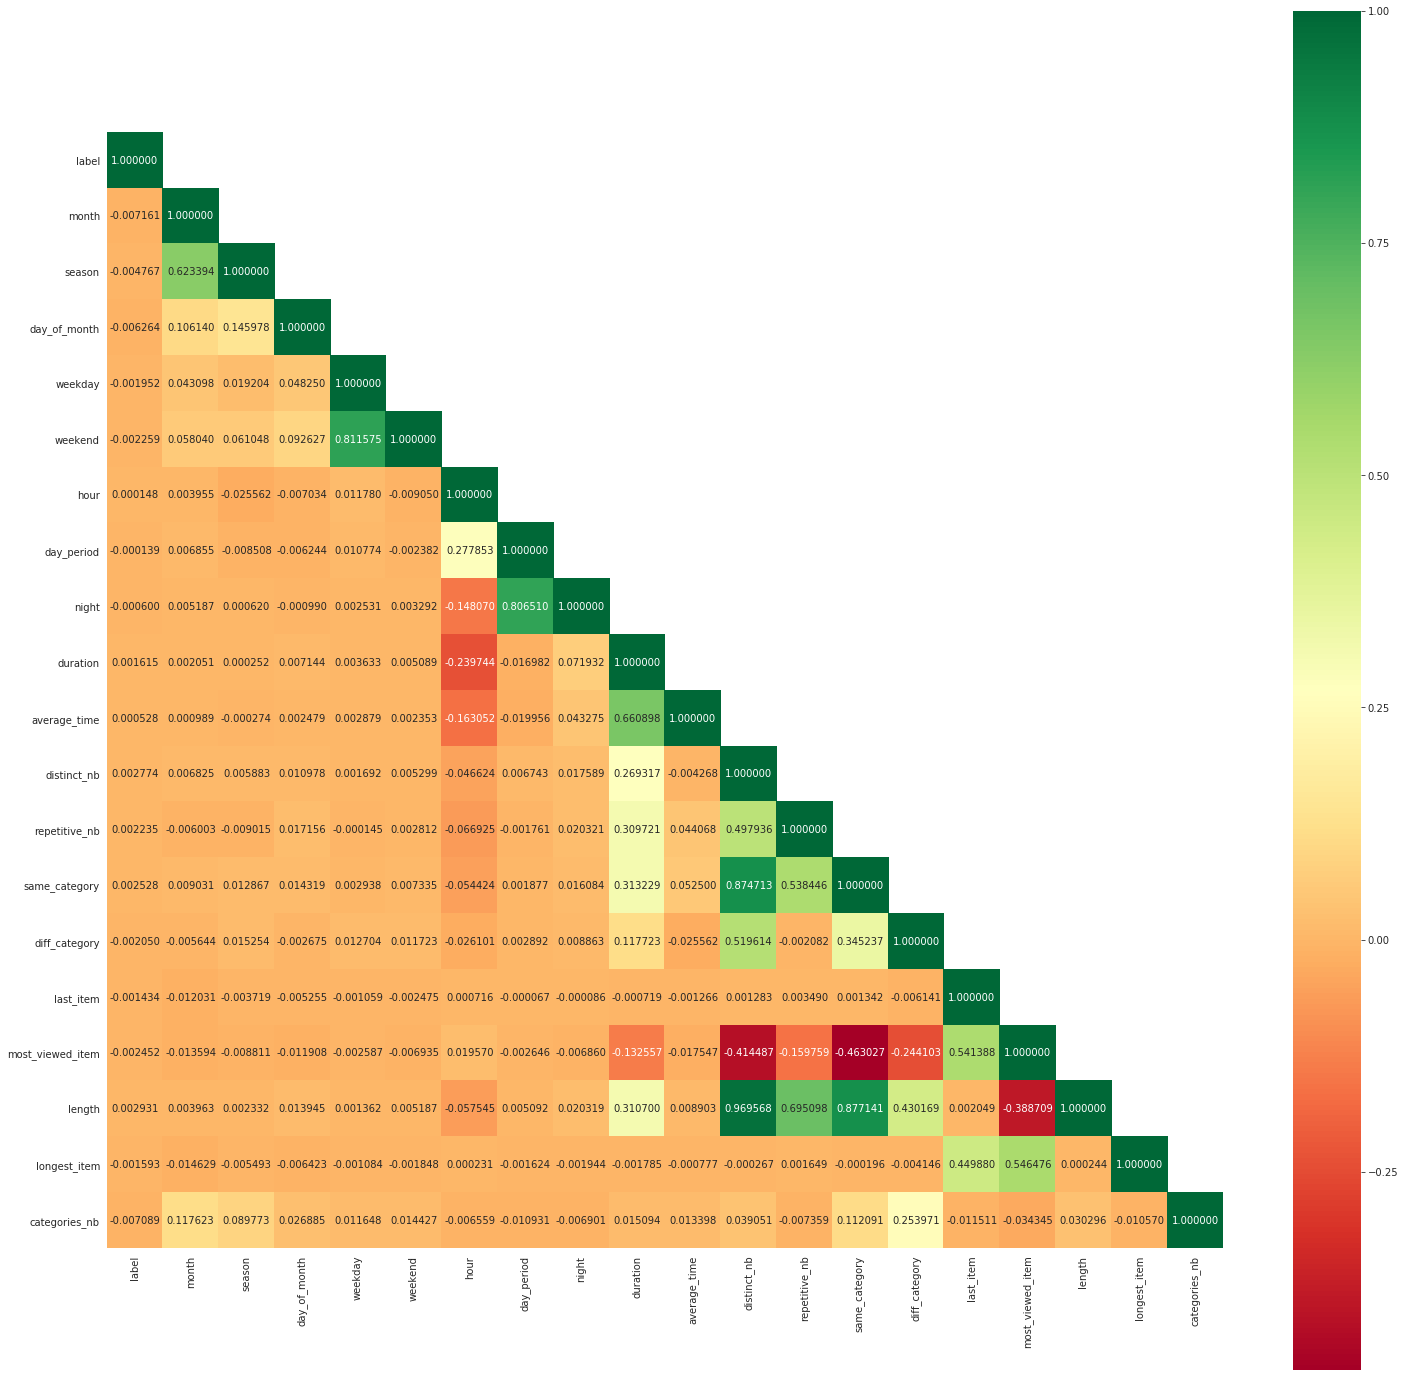

In [62]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



mask = np.zeros_like(mat)
mask[np.triu_indices_from(mask, 1)] = True
with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(25, 25))
    ax = sns.heatmap(mat, mask=mask, square=True, annot=True, fmt="f", cmap="RdYlGn", xticklabels=names, yticklabels=names)

## Forward feature selection

For the forward feature selection we chose the MRMR algorithm.

# Part 3 : Model

The model should be trained on the data with the selected features and should returned the predictions required by the competition. For each test session, the model should return 100 candidates items with the highest chance of being purchased. This restricts the differents models that can be used. Therefore the naive Bayes model was selected.

In [38]:
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Let's first transform our rdd which contains all the data into a dataframe which the classifier can use.

In [40]:
def collector(x):
    dico = {}
    dico["session_id"] = x[0]
    dico["item_id"] = x[1][0]
    for i in range(len(features_name)):
        dico[features_name[i]] = x[1][i+1]
    return dico
        

In [41]:
from pyspark.sql.types import Row
df = BIG_RDD.map(lambda x: Row(**collector(x))).toDF()

df = df.withColumnRenamed("item_id", "label")
df = VectorAssembler(inputCols = features_name, outputCol = "features", handleInvalid="skip").transform(df)
df = df.select(["features", "label"])

In [42]:
df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[10.0,3.0,11.0,0....|12090|
|[11.0,3.0,27.0,5....| 8060|
|[11.0,3.0,29.0,0....| 9478|
|[6.0,2.0,26.0,5.0...|15287|
|[7.0,2.0,7.0,2.0,...|  101|
+--------------------+-----+
only showing top 5 rows



Now we can split the dataset, 75% will be used for the training and the rest will be used for the test.

In [43]:
train, test = df.randomSplit([0.75, 0.25])

Now we can train our model with the training dataset.

In [44]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
model = nb.fit(train)

Finally we can test the accuracy of our model on the test dataset.

In [ ]:
pred = model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(pred) 
print("Test accuracy = " + str(nbaccuracy))

We can see that the accuracy of our model is quite low which can be explained by the large number of different items in the dataset. Even in the RecSys Challenge 2022, it asked for each session to give 100 items which have the highest probability.

Now we can get the predictions for the RecSys Challenge 2022's leaderboard.

First we load the specific dataset.

In [45]:
leaderboard_sessions = spark.read.csv("dressipi_recsys2022/test_leaderboard_sessions.csv", header=True)
leaderboard_sessions = leaderboard_sessions.withColumn("session_id", leaderboard_sessions["session_id"].cast("int"))
leaderboard_sessions = leaderboard_sessions.withColumn("item_id", leaderboard_sessions["item_id"].cast("int"))
leaderboard_sessions = leaderboard_sessions.withColumn("date", leaderboard_sessions["date"].cast("timestamp"))
train_sessions = leaderboard_sessions

Then we compute the values of all the different features.

In [46]:

session_item_date_rdd = leaderboard_sessions.rdd.map(lambda x: (x["session_id"], (x["item_id"], x["date"]))).cache()
session_item_rdd = session_item_date_rdd.mapValues(lambda x: (x[0])).cache()
session_date_rdd = session_item_date_rdd.mapValues(lambda x: (x[1])).cache()

month = get_month_feature()
season = get_season_feature()
day_of_month = get_day_of_month_feature()
weekday = get_weekday_feature()
weekend = get_weekend_feature()
hour = get_hour_feature()
day_period = get_day_period_feature()
night = get_night_feature()
duration = get_duration_feature()
average_time = get_average_time_feature()
distinct_nb = get_distinct_nb_feature()
repetitive_nb = get_repetitive_nb_feature()
same_category = get_same_category_feature()
diff_category = get_diff_category()
last_item = get_last_item_feature()
most_present_category = get_most_present_category_feature()
most_viewed_item = get_most_viewed_item_feature()
length = get_length_feature()
longest_item = get_longest_item_feature()
categories_nb = get_categories_nb_feature()
hash_items = get_hash_items_feature()

features = [month, season, day_of_month, weekday, weekend, hour, day_period, night, duration, average_time, distinct_nb, repetitive_nb, same_category, diff_category, last_item, most_viewed_item, length, longest_item, categories_nb]
test_rdd = features[0].join(features[1])
for i in range(2, len(features)):
    feature = features[i]
    test_rdd = test_rdd.join(feature).mapValues(lambda x: list(x[0])+[x[1]])


In [47]:
test_rdd.take(1)

[(3040950,
  [6,
   2,
   5,
   6,
   1,
   18,
   3,
   1,
   0.0,
   0.0,
   1,
   0,
   0,
   21,
   20504,
   20504,
   1,
   20504,
   21.0])]

Next we transform our RDD to a dataframe which can be used by our model.

In [49]:
def test_collector(x):
    dico = {}
    dico["session_id"] = x[0]
    for i in range(len(features_name)):
        dico[features_name[i]] = x[1][i]
    return dico


test_df = test_rdd.map(lambda x: Row(**test_collector(x))).toDF()

test_df = VectorAssembler(inputCols = features_name, outputCol = "features", handleInvalid="skip").transform(test_df)
test_df = test_df.select(["features", "session_id"])

In [50]:
test_df.show(5)

+--------------------+----------+
|            features|session_id|
+--------------------+----------+
|[6.0,2.0,5.0,6.0,...|   3040950|
|[6.0,2.0,23.0,3.0...|     62700|
|[6.0,2.0,5.0,6.0,...|    176550|
|[6.0,2.0,1.0,2.0,...|     19800|
|[6.0,2.0,8.0,2.0,...|   3582150|
+--------------------+----------+
only showing top 5 rows



We create a new naive Bayes model that will be trained on the whole dataset.

In [51]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
model = nb.fit(df)

Finally we gather all the results we computed and save them to a CSV file with the structures asked by the RecSys Challenge 2022.

In [52]:
pred = model.transform(test_df)

In [53]:
pred.show(1)

+--------------------+----------+--------------------+--------------------+----------+
|            features|session_id|       rawPrediction|         probability|prediction|
+--------------------+----------+--------------------+--------------------+----------+
|[6.0,2.0,5.0,6.0,...|   3040950|[-73581.314254785...|[0.0,0.0,0.0,0.0,...|   11157.0|
+--------------------+----------+--------------------+--------------------+----------+
only showing top 1 row



In [54]:
from ipywidgets import IntProgress
from IPython.display import display

In [55]:
progressbar = IntProgress(min=0, max=pred.count())
display(progressbar)

#pred_iterator = pred.select("probability").rdd.toLocalIterator()
pred_iterator = pred.rdd.toLocalIterator()
session_id = 1
with open("predictions2.csv", "w") as file:
    file.write("session_id,item_id,rank\n")
    for row in pred_iterator:
        # print(f"Starting session {session_id} / {pred.count()}")
        
        temp = list(row["probability"])

        temp = [(temp[i], i) for i in range(len(temp))]
        temp.sort(reverse=True)
        
        temp = temp[:100]
        for l in range(100):
            file.write(f"{row['session_id']},{temp[l][1]},{l+1}\n")
        
        progressbar.value += 1
        session_id += 1

IntProgress(value=0, max=50000)

In [ ]:
spark.stop()